# Импортирование необходимых библиотек

In [1]:
import numpy as np 
import pandas as pd 
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import random

from torchvision import transforms, models

In [4]:
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
# путь к датасету
data_root = '/kaggle/input/file-8/kaggle/working'
print(os.listdir(data_root))

['predictions', 'test', 'train']


In [6]:
train_dir = 'train'
val_dir = 'val'
each_val_img_ind = 6 #валидация каждое 6-ое изображение будем класть в валидацию

class_names = ['asymmetric', 'symmetric']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % each_val_img_ind  != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 406.71it/s]


In [7]:
!dir train

asymmetric  symmetric


# Применение аугментаций

In [8]:
train_transforms = [
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.3, hue=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        
    transforms.Compose([
    transforms.RandomRotation(45),
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomGrayscale(p=1),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.4, hue=0.4),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
]
val_transforms = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir,train_transform)
                                                    for train_transform in train_transforms])

val_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(val_dir,train_transform)
                                                    for train_transform in train_transforms])

batch_size = 3
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size) # 3 процесса загрузки бачей

In [9]:
print("train size : {} val size : {}".format(len(train_dataloader), len(val_dataloader)))

train size : 61 val size : 14


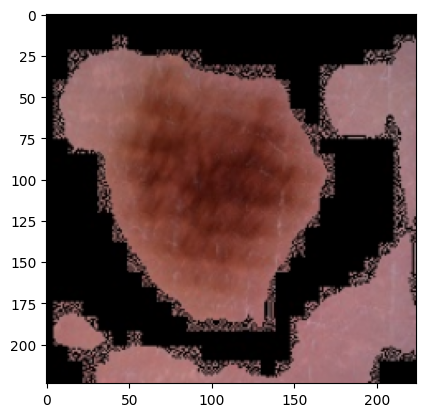

In [10]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

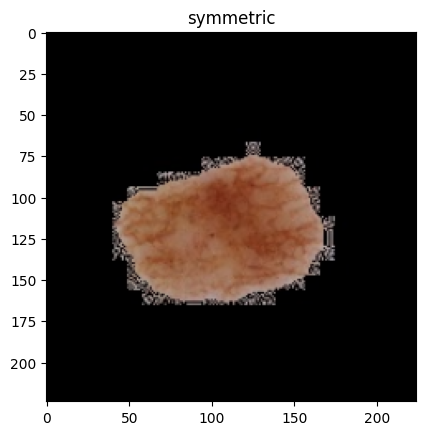

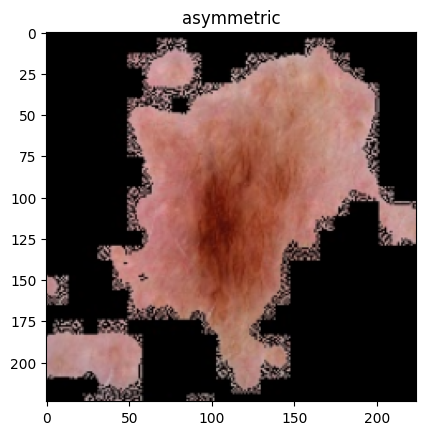

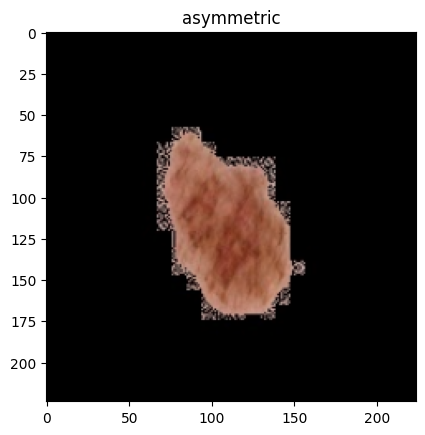

In [11]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

# Create custom neural network

In [12]:
class CustomNeuralNetResNet(torch.nn.Module):
    def __init__(self,outputs_number):
        super(CustomNeuralNetResNet, self).__init__()
#         self.net = models.resnet50(pretrained=True)
#         self.net = models.resnext50_32x4d(pretrained=True)
#         self.net = models.resnext101_64x4d(pretrained=True)
#         self.net = models.resnet18(pretrained=True)
        self.net = models.resnet152(pretrained=True)

        # Выключаем переобучение весов каждого слоя модели, кроме последнего
        for param in self.net.parameters():
            param.requires_grad = False
        
#         for param in self.net.layer4.parameters():
#             param.requires_grad = True
        
#         for param in self.net.layer3.parameters():
#             param.requires_grad = True


        TransferModelOutputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(TransferModelOutputs, outputs_number)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
model = CustomNeuralNetResNet(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True) #, betas=(0.99, 0.9999)), смотреть предыдущие градиенты для лучшей сходимости


# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 156MB/s]  


# Train model

In [14]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_weights = None
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_val_acc =  epoch_acc
                    best_model_weights = model.state_dict()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    if best_model_weights is not None:
        torch.save(best_model_weights, 'best_model.pth')
        print('Best model saved with loss:', best_val_loss, best_val_acc)

    return train_loss, val_loss, train_acc, val_acc

In [15]:
train_loss, val_loss, train_acc, val_acc = train_model(model, loss, optimizer, scheduler, num_epochs=50)

Epoch 0/49:


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 61/61 [00:03<00:00, 18.16it/s]

train Loss: 0.7867 Acc: 0.5738



100%|██████████| 14/14 [00:00<00:00, 26.45it/s]

val Loss: 0.5362 Acc: 0.6905
Epoch 1/49:



100%|██████████| 61/61 [00:02<00:00, 30.37it/s]

train Loss: 0.7054 Acc: 0.6557



100%|██████████| 14/14 [00:00<00:00, 27.98it/s]

val Loss: 0.5451 Acc: 0.7143
Epoch 2/49:



100%|██████████| 61/61 [00:02<00:00, 30.43it/s]

train Loss: 0.5507 Acc: 0.6913



100%|██████████| 14/14 [00:00<00:00, 26.84it/s]

val Loss: 0.5171 Acc: 0.8095
Epoch 3/49:



100%|██████████| 61/61 [00:01<00:00, 31.07it/s]

train Loss: 0.5261 Acc: 0.7240



100%|██████████| 14/14 [00:00<00:00, 27.82it/s]

val Loss: 1.1543 Acc: 0.3571
Epoch 4/49:



100%|██████████| 61/61 [00:02<00:00, 27.52it/s]

train Loss: 0.4886 Acc: 0.7787



100%|██████████| 14/14 [00:00<00:00, 28.12it/s]

val Loss: 0.5010 Acc: 0.8571
Epoch 5/49:



100%|██████████| 61/61 [00:02<00:00, 30.17it/s]

train Loss: 0.4563 Acc: 0.8251



100%|██████████| 14/14 [00:00<00:00, 26.58it/s]

val Loss: 0.6023 Acc: 0.7381
Epoch 6/49:



100%|██████████| 61/61 [00:02<00:00, 29.94it/s]

train Loss: 0.4131 Acc: 0.8197



100%|██████████| 14/14 [00:00<00:00, 27.61it/s]

val Loss: 0.5245 Acc: 0.7857
Epoch 7/49:



100%|██████████| 61/61 [00:01<00:00, 30.75it/s]

train Loss: 0.4625 Acc: 0.7869



100%|██████████| 14/14 [00:00<00:00, 27.45it/s]

val Loss: 0.5276 Acc: 0.8095
Epoch 8/49:



100%|██████████| 61/61 [00:02<00:00, 29.11it/s]

train Loss: 0.4135 Acc: 0.8142



100%|██████████| 14/14 [00:00<00:00, 27.33it/s]

val Loss: 0.5776 Acc: 0.8095
Epoch 9/49:



100%|██████████| 61/61 [00:02<00:00, 29.95it/s]

train Loss: 0.4103 Acc: 0.8415



100%|██████████| 14/14 [00:00<00:00, 27.54it/s]

val Loss: 0.6745 Acc: 0.6905
Epoch 10/49:



100%|██████████| 61/61 [00:02<00:00, 29.60it/s]

train Loss: 0.4498 Acc: 0.7951



100%|██████████| 14/14 [00:00<00:00, 27.34it/s]

val Loss: 0.5932 Acc: 0.7143
Epoch 11/49:



100%|██████████| 61/61 [00:02<00:00, 29.85it/s]

train Loss: 0.4183 Acc: 0.8060



100%|██████████| 14/14 [00:00<00:00, 27.55it/s]

val Loss: 0.5170 Acc: 0.8095
Epoch 12/49:



100%|██████████| 61/61 [00:02<00:00, 29.10it/s]

train Loss: 0.4496 Acc: 0.8333



100%|██████████| 14/14 [00:00<00:00, 27.53it/s]

val Loss: 0.5367 Acc: 0.8095
Epoch 13/49:



100%|██████████| 61/61 [00:02<00:00, 30.12it/s]

train Loss: 0.4148 Acc: 0.8415



100%|██████████| 14/14 [00:00<00:00, 26.36it/s]

val Loss: 0.5592 Acc: 0.7619
Epoch 14/49:



100%|██████████| 61/61 [00:02<00:00, 29.71it/s]

train Loss: 0.4322 Acc: 0.8087



100%|██████████| 14/14 [00:00<00:00, 26.88it/s]

val Loss: 0.5721 Acc: 0.8095
Epoch 15/49:



100%|██████████| 61/61 [00:02<00:00, 30.01it/s]

train Loss: 0.4165 Acc: 0.8224



100%|██████████| 14/14 [00:00<00:00, 27.06it/s]

val Loss: 0.5912 Acc: 0.7143
Epoch 16/49:



100%|██████████| 61/61 [00:02<00:00, 27.49it/s]

train Loss: 0.4196 Acc: 0.8333



100%|██████████| 14/14 [00:00<00:00, 27.83it/s]

val Loss: 0.5533 Acc: 0.7857
Epoch 17/49:



100%|██████████| 61/61 [00:02<00:00, 29.87it/s]

train Loss: 0.4180 Acc: 0.8770



100%|██████████| 14/14 [00:00<00:00, 27.54it/s]

val Loss: 0.6179 Acc: 0.6667
Epoch 18/49:



100%|██████████| 61/61 [00:02<00:00, 29.85it/s]

train Loss: 0.4919 Acc: 0.7596



100%|██████████| 14/14 [00:00<00:00, 27.11it/s]

val Loss: 0.5506 Acc: 0.7857
Epoch 19/49:



100%|██████████| 61/61 [00:02<00:00, 30.16it/s]

train Loss: 0.4517 Acc: 0.7923



100%|██████████| 14/14 [00:00<00:00, 26.97it/s]

val Loss: 0.4931 Acc: 0.7857
Epoch 20/49:



100%|██████████| 61/61 [00:02<00:00, 27.53it/s]

train Loss: 0.4453 Acc: 0.8005



100%|██████████| 14/14 [00:00<00:00, 27.48it/s]

val Loss: 0.6305 Acc: 0.6429
Epoch 21/49:



100%|██████████| 61/61 [00:02<00:00, 29.45it/s]

train Loss: 0.4748 Acc: 0.8087



100%|██████████| 14/14 [00:00<00:00, 26.57it/s]

val Loss: 0.6856 Acc: 0.6429
Epoch 22/49:



100%|██████████| 61/61 [00:02<00:00, 29.36it/s]

train Loss: 0.4190 Acc: 0.8470



100%|██████████| 14/14 [00:00<00:00, 27.54it/s]

val Loss: 0.5000 Acc: 0.8095
Epoch 23/49:



100%|██████████| 61/61 [00:02<00:00, 29.17it/s]

train Loss: 0.4255 Acc: 0.8197



100%|██████████| 14/14 [00:00<00:00, 25.88it/s]

val Loss: 0.4460 Acc: 0.7857
Epoch 24/49:



100%|██████████| 61/61 [00:02<00:00, 29.51it/s]

train Loss: 0.4510 Acc: 0.8087



100%|██████████| 14/14 [00:00<00:00, 26.88it/s]

val Loss: 0.5796 Acc: 0.6190
Epoch 25/49:



100%|██████████| 61/61 [00:02<00:00, 29.20it/s]

train Loss: 0.4099 Acc: 0.8443



100%|██████████| 14/14 [00:00<00:00, 26.90it/s]

val Loss: 0.6184 Acc: 0.7619
Epoch 26/49:



100%|██████████| 61/61 [00:02<00:00, 29.35it/s]

train Loss: 0.4266 Acc: 0.8033



100%|██████████| 14/14 [00:00<00:00, 27.12it/s]

val Loss: 0.5699 Acc: 0.8095
Epoch 27/49:



100%|██████████| 61/61 [00:02<00:00, 28.87it/s]

train Loss: 0.4348 Acc: 0.8361



100%|██████████| 14/14 [00:00<00:00, 26.99it/s]

val Loss: 0.5795 Acc: 0.7857
Epoch 28/49:



100%|██████████| 61/61 [00:02<00:00, 28.21it/s]

train Loss: 0.4257 Acc: 0.8306



100%|██████████| 14/14 [00:00<00:00, 27.03it/s]

val Loss: 0.5918 Acc: 0.7857
Epoch 29/49:



100%|██████████| 61/61 [00:02<00:00, 29.23it/s]

train Loss: 0.4307 Acc: 0.8087



100%|██████████| 14/14 [00:00<00:00, 27.07it/s]

val Loss: 0.5389 Acc: 0.8571
Epoch 30/49:



100%|██████████| 61/61 [00:02<00:00, 29.10it/s]

train Loss: 0.3861 Acc: 0.8525



100%|██████████| 14/14 [00:00<00:00, 26.68it/s]

val Loss: 0.5791 Acc: 0.7857
Epoch 31/49:



100%|██████████| 61/61 [00:02<00:00, 28.23it/s]

train Loss: 0.3924 Acc: 0.8361



100%|██████████| 14/14 [00:00<00:00, 26.50it/s]

val Loss: 0.6207 Acc: 0.6905
Epoch 32/49:



100%|██████████| 61/61 [00:02<00:00, 29.29it/s]

train Loss: 0.4336 Acc: 0.8087



100%|██████████| 14/14 [00:00<00:00, 27.32it/s]

val Loss: 0.5676 Acc: 0.7143
Epoch 33/49:



100%|██████████| 61/61 [00:02<00:00, 29.15it/s]

train Loss: 0.4165 Acc: 0.8525



100%|██████████| 14/14 [00:00<00:00, 26.77it/s]

val Loss: 0.5529 Acc: 0.7143
Epoch 34/49:



100%|██████████| 61/61 [00:02<00:00, 28.61it/s]

train Loss: 0.4249 Acc: 0.8251



100%|██████████| 14/14 [00:00<00:00, 26.91it/s]

val Loss: 0.5720 Acc: 0.7143
Epoch 35/49:



100%|██████████| 61/61 [00:02<00:00, 28.11it/s]

train Loss: 0.4663 Acc: 0.8060



100%|██████████| 14/14 [00:00<00:00, 26.50it/s]

val Loss: 0.6509 Acc: 0.6667
Epoch 36/49:



100%|██████████| 61/61 [00:02<00:00, 28.59it/s]

train Loss: 0.3994 Acc: 0.8306



100%|██████████| 14/14 [00:00<00:00, 26.30it/s]

val Loss: 0.6757 Acc: 0.7857
Epoch 37/49:



100%|██████████| 61/61 [00:02<00:00, 29.08it/s]

train Loss: 0.4130 Acc: 0.8169



100%|██████████| 14/14 [00:00<00:00, 26.64it/s]

val Loss: 0.6021 Acc: 0.6667
Epoch 38/49:



100%|██████████| 61/61 [00:02<00:00, 28.64it/s]

train Loss: 0.4842 Acc: 0.8087



100%|██████████| 14/14 [00:00<00:00, 26.28it/s]

val Loss: 0.6621 Acc: 0.6667
Epoch 39/49:



100%|██████████| 61/61 [00:02<00:00, 28.80it/s]

train Loss: 0.4364 Acc: 0.8197



100%|██████████| 14/14 [00:00<00:00, 25.93it/s]

val Loss: 0.6504 Acc: 0.6667
Epoch 40/49:



100%|██████████| 61/61 [00:02<00:00, 28.18it/s]

train Loss: 0.4057 Acc: 0.8415



100%|██████████| 14/14 [00:00<00:00, 26.60it/s]

val Loss: 0.5587 Acc: 0.6429
Epoch 41/49:



100%|██████████| 61/61 [00:02<00:00, 29.28it/s]

train Loss: 0.4308 Acc: 0.8033



100%|██████████| 14/14 [00:00<00:00, 26.42it/s]

val Loss: 0.5826 Acc: 0.8095
Epoch 42/49:



100%|██████████| 61/61 [00:02<00:00, 28.46it/s]

train Loss: 0.4000 Acc: 0.8470



100%|██████████| 14/14 [00:00<00:00, 26.81it/s]

val Loss: 0.6104 Acc: 0.6905
Epoch 43/49:



100%|██████████| 61/61 [00:02<00:00, 29.18it/s]

train Loss: 0.4498 Acc: 0.8115



100%|██████████| 14/14 [00:00<00:00, 26.19it/s]

val Loss: 0.5862 Acc: 0.7857
Epoch 44/49:



100%|██████████| 61/61 [00:02<00:00, 29.34it/s]

train Loss: 0.4287 Acc: 0.8333



100%|██████████| 14/14 [00:00<00:00, 27.22it/s]

val Loss: 0.5872 Acc: 0.7381
Epoch 45/49:



100%|██████████| 61/61 [00:02<00:00, 29.03it/s]

train Loss: 0.4317 Acc: 0.7760



100%|██████████| 14/14 [00:00<00:00, 27.02it/s]

val Loss: 0.5909 Acc: 0.6429
Epoch 46/49:



100%|██████████| 61/61 [00:02<00:00, 28.73it/s]

train Loss: 0.4155 Acc: 0.8306



100%|██████████| 14/14 [00:00<00:00, 27.19it/s]

val Loss: 0.5984 Acc: 0.6667
Epoch 47/49:



100%|██████████| 61/61 [00:02<00:00, 29.67it/s]

train Loss: 0.3845 Acc: 0.8579



100%|██████████| 14/14 [00:00<00:00, 27.10it/s]

val Loss: 0.5972 Acc: 0.6429
Epoch 48/49:



100%|██████████| 61/61 [00:02<00:00, 29.18it/s]

train Loss: 0.4047 Acc: 0.8743



100%|██████████| 14/14 [00:00<00:00, 26.92it/s]

val Loss: 0.6166 Acc: 0.8095
Epoch 49/49:



100%|██████████| 61/61 [00:02<00:00, 29.27it/s]

train Loss: 0.4273 Acc: 0.8251



100%|██████████| 14/14 [00:00<00:00, 26.76it/s]

val Loss: 0.6173 Acc: 0.6905


Best model saved with loss: 0.4459539641227041 tensor(0.7857, device='cuda:0')


In [16]:
train_loss = train_loss.numpy()
val_loss = val_loss.numpy()
train_acc = train_acc.numpy()
val_acc = val_acc.numpy()

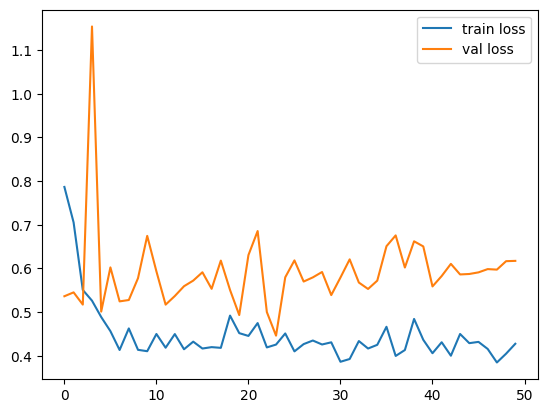

In [17]:
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.legend(loc='best')
plt.show()

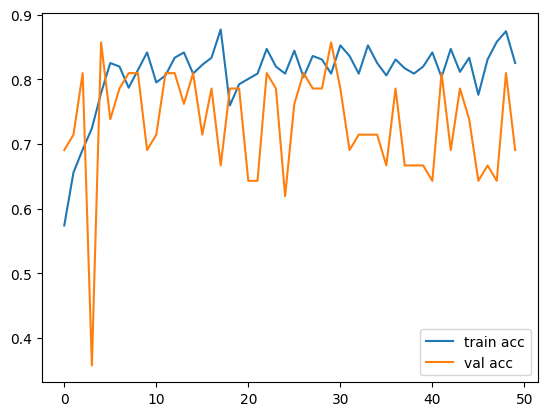

In [18]:
plt.plot(train_acc, label = 'train acc')
plt.plot(val_acc, label = 'val acc')
plt.legend(loc='best')
plt.show()

In [19]:
# data_root = '/kaggle/input/file-2/kaggle/working'
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [20]:
!nvidia-smi

Sun Jun 16 10:37:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0              29W /  70W |    669MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
# torch.save(model.state_dict(), 'model_weights.pth')

In [30]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

<All keys matched successfully>

In [31]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_data = 'test/'
test_dataset = ImageFolderWithPaths(test_data, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [32]:
def get_predictions(dataloader):
    model.eval()
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)

    test_predictions = np.concatenate(test_predictions)
    return test_predictions, test_img_paths

test_predictions, test_img_paths = get_predictions(test_dataloader)

100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


# Post Hoc анализ

/tmp/ipykernel_34/729151678.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(pred).data.cpu().numpy()


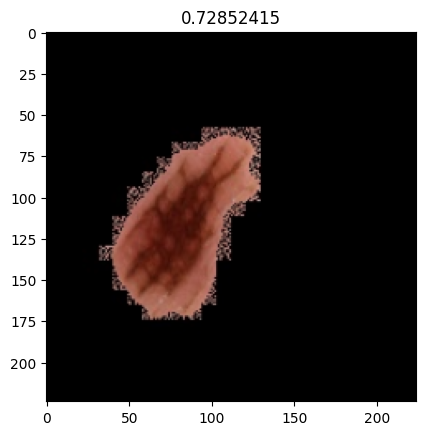

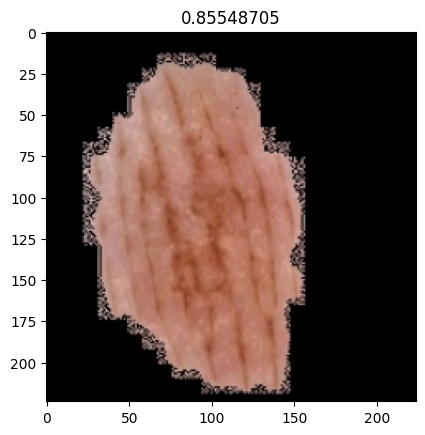

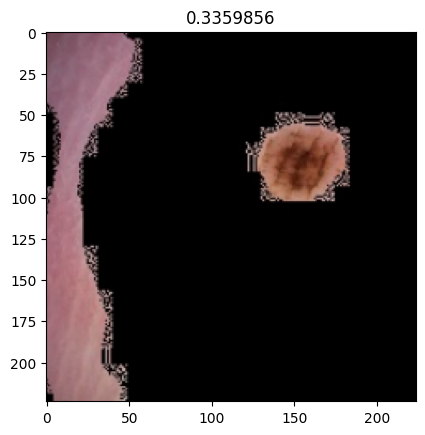

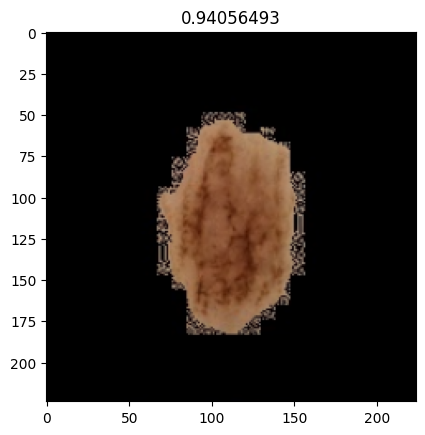

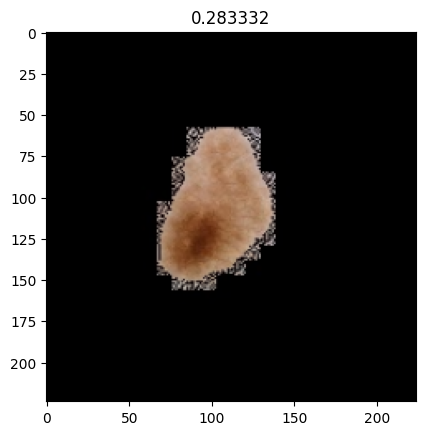

In [33]:
n_images = 2
iter_obj = iter(test_dataloader)

for _ in range(n_images):
    inputs, labels, paths = next(iter_obj)
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    for img, pred in zip(inputs, preds):
            pred = torch.nn.functional.softmax(pred).data.cpu().numpy()
            img = img.cpu()
            show_input(img, title=pred[1])


In [35]:
test_predictions[test_predictions < 0.4].shape

(2,)

In [36]:
test_predictions.shape

(5,)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

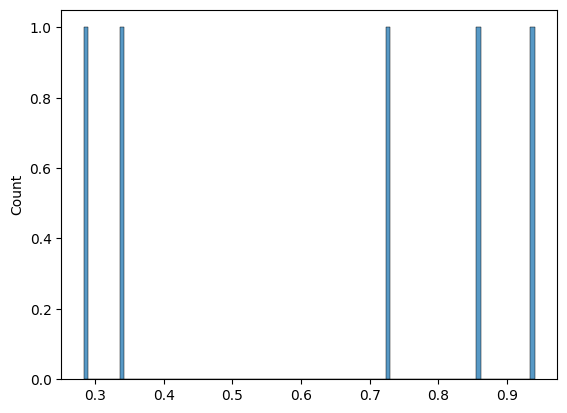

In [37]:
sns.histplot(test_predictions, bins = 100)

Распределение

/tmp/ipykernel_34/577843960.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.softmax(pred).data.cpu().numpy()


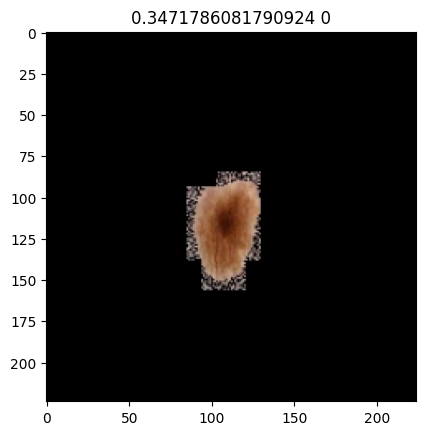

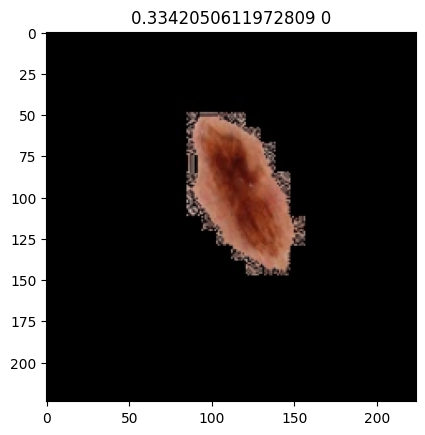

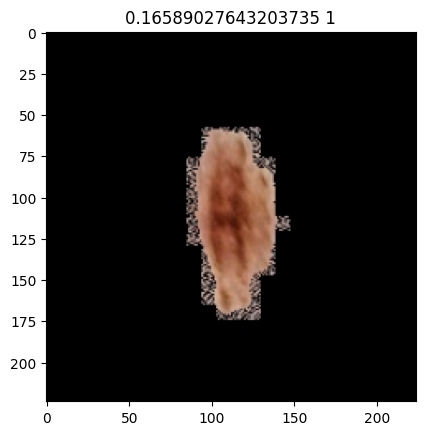

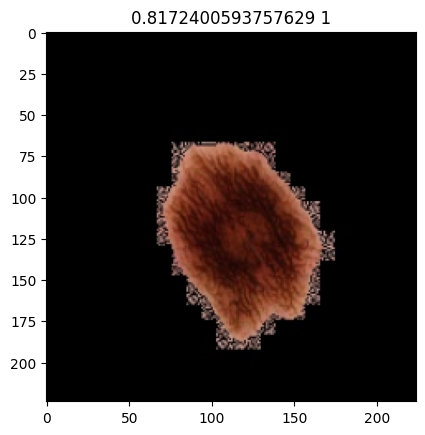

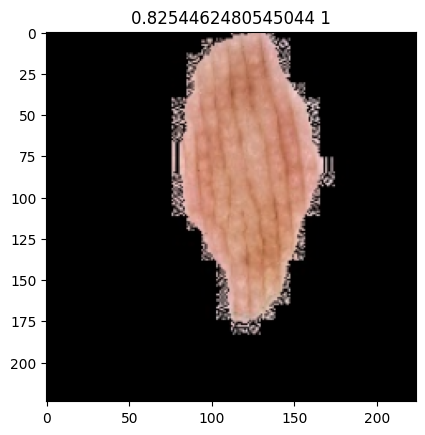

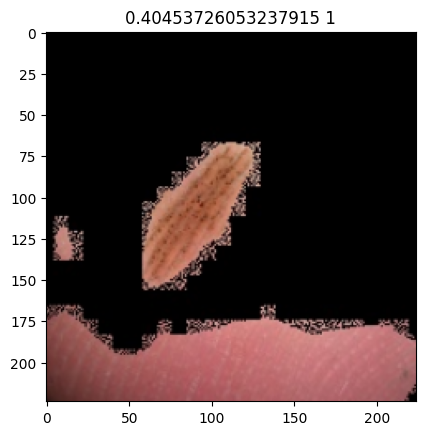

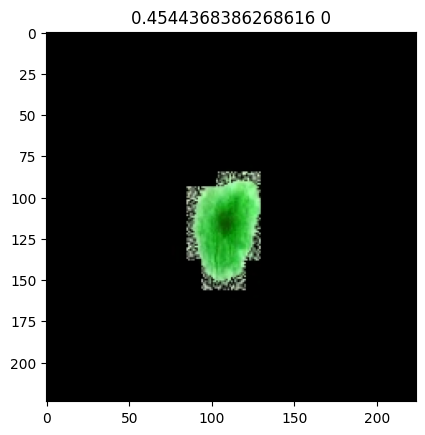

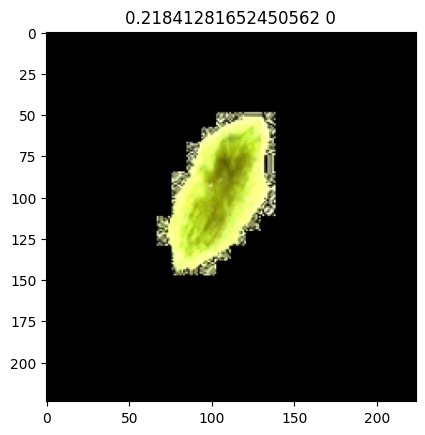

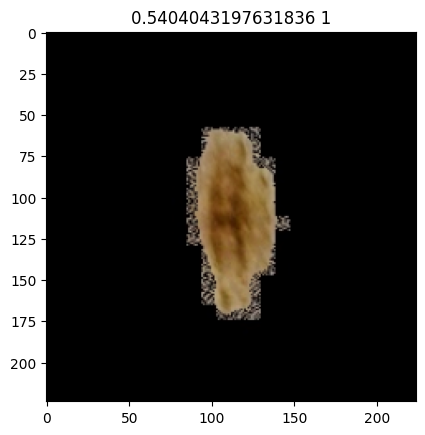

In [38]:
n_images = 3
iter_obj = iter(val_dataloader)

# X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=class_names[y_item])

dirty_probs = []
clean_probs = []

for _ in range(n_images):
    X_batch, y_batch = next(iter(iter_obj))
    X_batch = X_batch.to(device)
    with torch.set_grad_enabled(False):
        preds = model(X_batch)
    for img, pred_label in zip(X_batch, zip(preds, y_batch)):
            pred, label = pred_label
            pred = torch.nn.functional.softmax(pred).data.cpu().numpy()
            pred = pred[1]
            img = img.cpu()
            show_input(img, title="{} {}".format(pred, label))

In [175]:
import os
import shutil

# Получаем список файлов и директорий в /kaggle/working/
files = os.listdir('/kaggle/working/')

# Удаляем каждый файл и директорию
for file in files:
    if os.path.isfile(file):
        os.remove(file)  # Удалить файл
    else:
        shutil.rmtree(file)  # Удалить директорию
